   # Data science division fellowship program: STATISTICS CANADA


## Assignment 2: Machine Learning - Natural disasters dataset

### Objective
In this project I will use the Natural Language processing to classify tweets as either being about a real disater or not by using the simplest model that balance between explainability with performance and achieves sufficiently high accuracy.

# Task 1

### Table of contents
1. Import Libraries
2. Import Data
3. Exploratory data analysis
4. Data cleaning
5. Bag of words model
6. TF-IDF  
7. Pre-trained word embeddings and linear classifier model
8. Conclusion and recommendationsConclusion and recommendations


### 1. Import Libraries

In [146]:
import gc
import re
import string
import operator
from collections import defaultdict
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
SEED = 1234
import warnings
warnings.filterwarnings('ignore')

### 2. Import Data

In [2]:
df_train = pd.read_csv('/Users/basmazahraoui/Desktop/tweet desaster/train.csv')
df_test = pd.read_csv('/Users/basmazahraoui/Desktop/tweet desaster/test.csv')

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### 3. Exploratory data analysis

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


I found missing values in both features keyword and location

#### 3.1 Missing Values

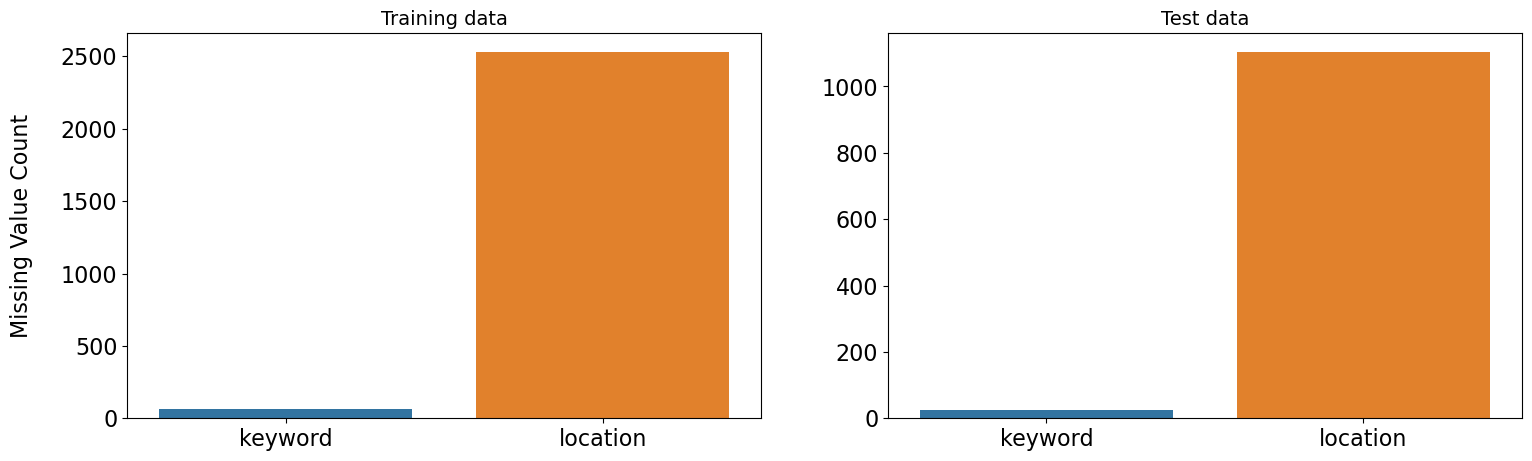

In [5]:
missing_features = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(18, 5), dpi=100)

sb.barplot(x=df_train[missing_features].isnull().sum().index, y=df_train[missing_features].isnull().sum().values, ax=axes[0])
sb.barplot(x=df_test[missing_features].isnull().sum().index, y=df_test[missing_features].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=16, labelpad=20)
axes[0].tick_params(axis='x', labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)
axes[1].tick_params(axis='x', labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)

axes[0].set_title('Training data', fontsize=14)
axes[1].set_title('Test data', fontsize=14)

plt.show()

for df in [df_train, df_test]:
    for feature in ['keyword', 'location']:
        df[feature] = df[feature].fillna(f'no_{feature}')

Both training and test data have the same ratio of missing values in location and keyword.
- 33% of location is missing in both training and test data.
- 0.8% of keyword is missing in both training and test data


In [6]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


I will not use location as a feature because this variable contains too many unique value in it.

#### 3.2 Target distribution 

in this step,I will show the target distribution.
- 1 = a real desaster
- 0 = not a real desaster

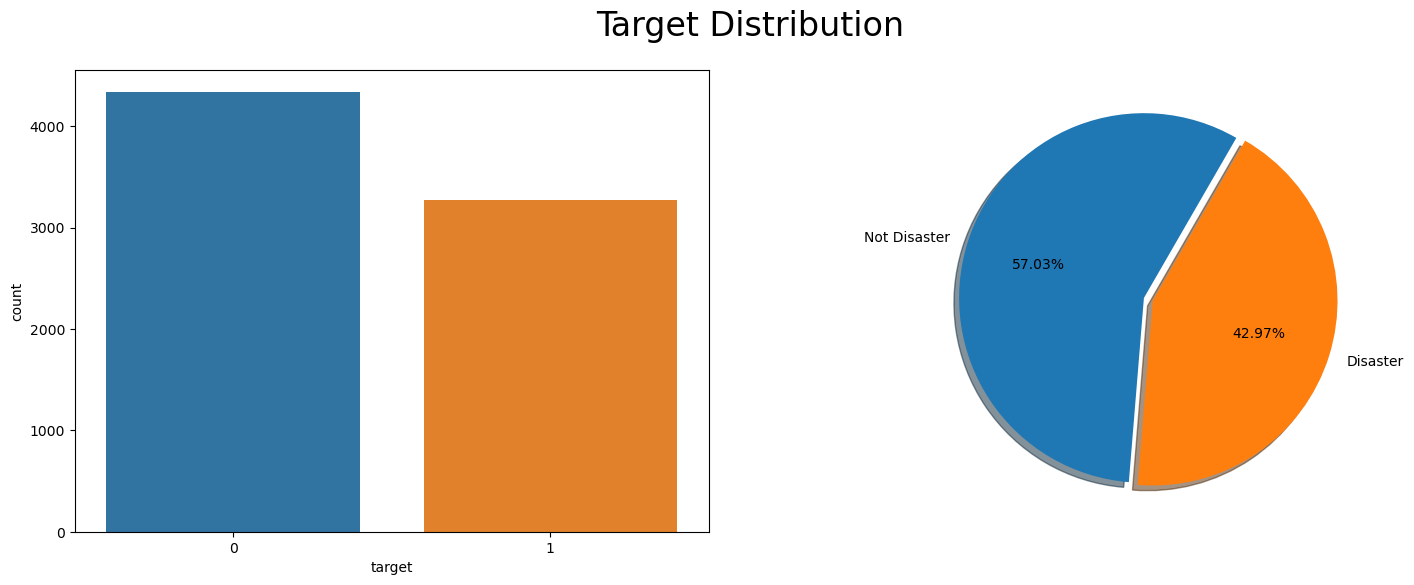

In [15]:
# Target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sb.countplot(df_train['target'], ax=axes[0])
axes[1].pie(df_train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Target Distribution', fontsize=24)
plt.show()


Class distributions are 57% for 0 (Not a disaster) and 43% for 1 (a disaster).

#### 3.3 Target distribution in keywords

Below we can see the average target distribution in keywords.

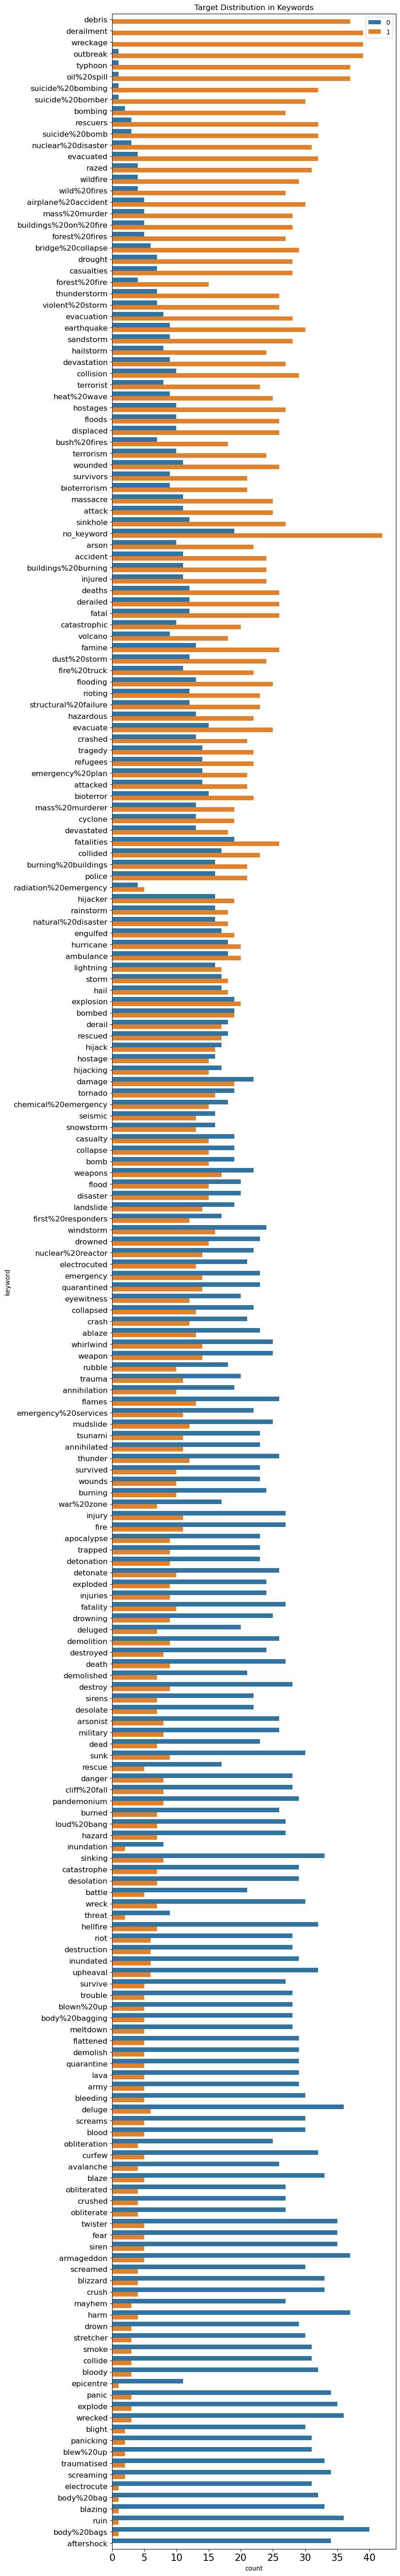

In [7]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sb.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

#### 3.4 Number of characters in tweets

In [22]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

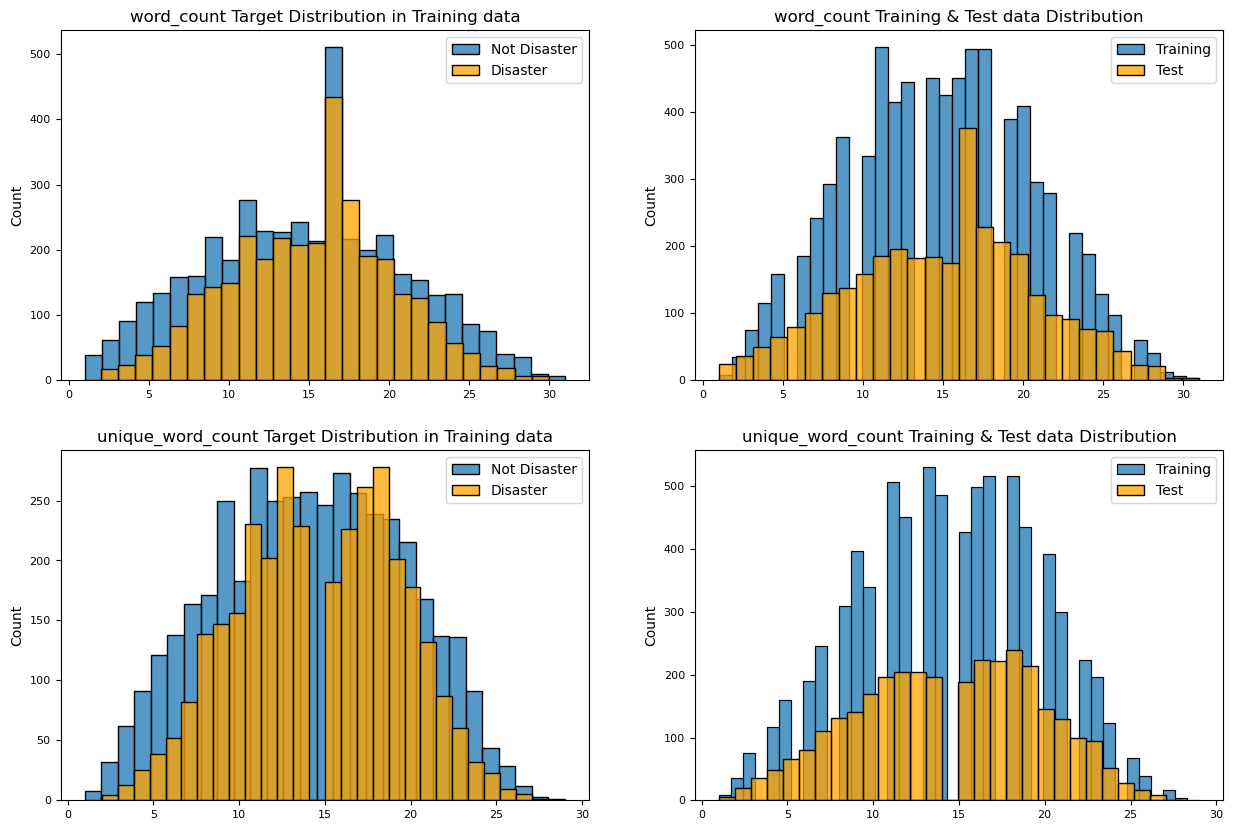

In [39]:
METAFEATURES = ['word_count', 'unique_word_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sb.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0] )
    sb.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0],color = "orange")

    sb.histplot(df_train[feature], label='Training', ax=axes[i][1])
    sb.histplot(df_test[feature], label='Test', ax=axes[i][1],color = "orange" )
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=8)
        axes[i][j].tick_params(axis='y', labelsize=8)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training data', fontsize=12)
    axes[i][1].set_title(f'{feature} Training & Test data Distribution', fontsize=12)

plt.show()

As we can se from the plots, word_count, unique_word_count have different distributions for disaster and non-disaster tweets. 

#### 3.5 N-grams

##### 3.5.1 Unigrams

In [41]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 20

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

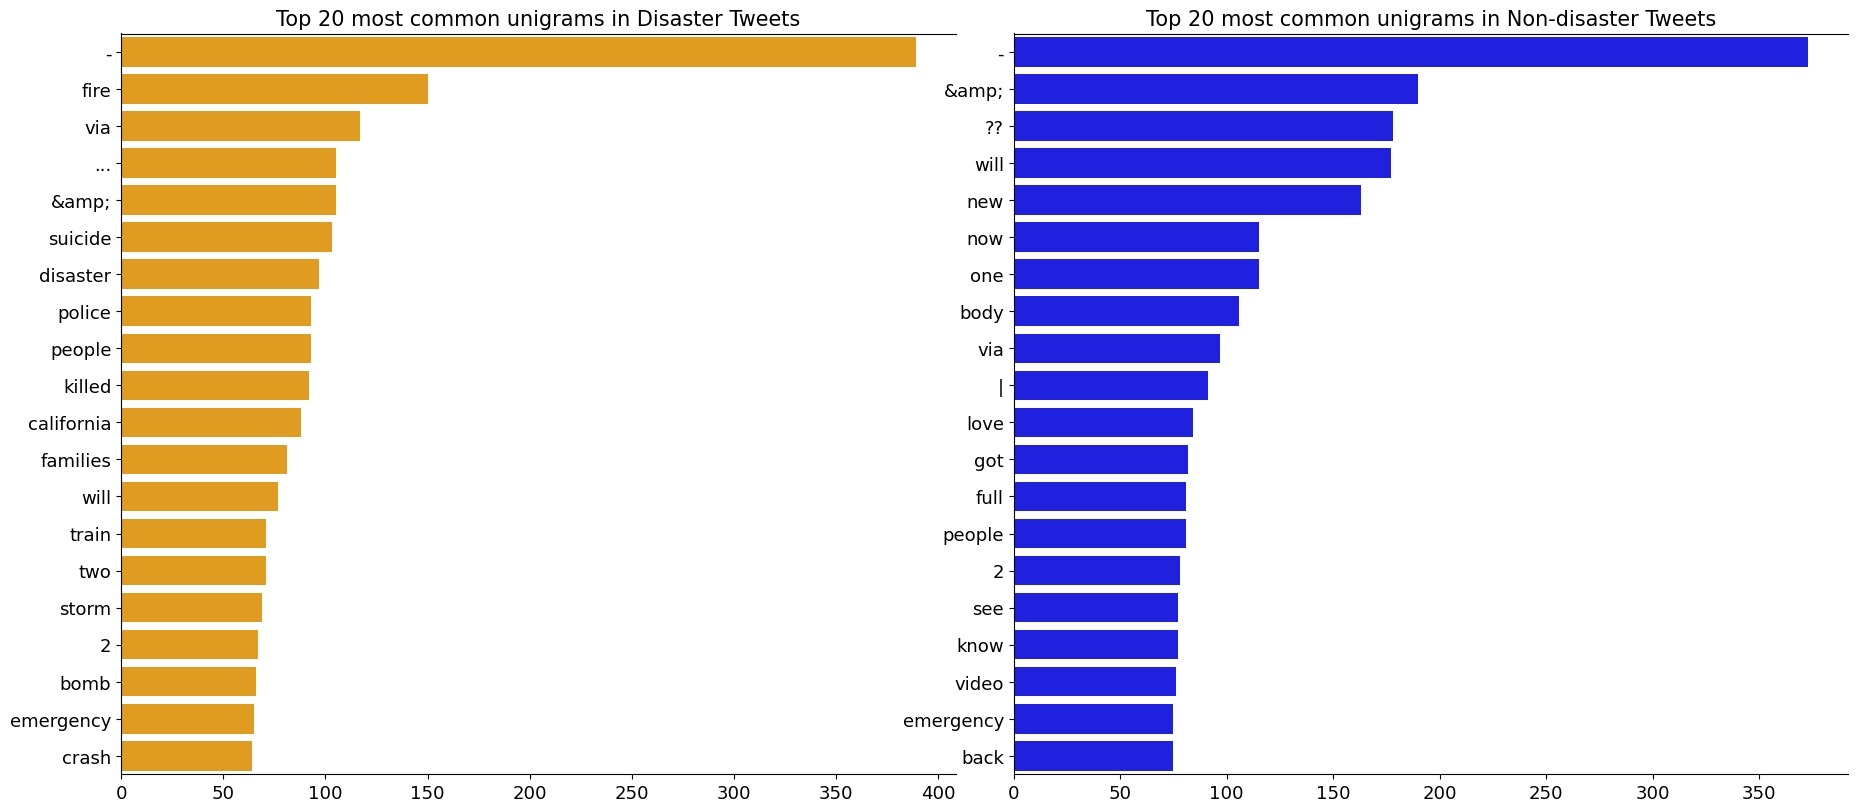

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8), dpi=100)
plt.tight_layout()

sb.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='orange')
sb.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

- Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.
- There are some common unirams in both classes.

##### 3.5.2 Bigrams

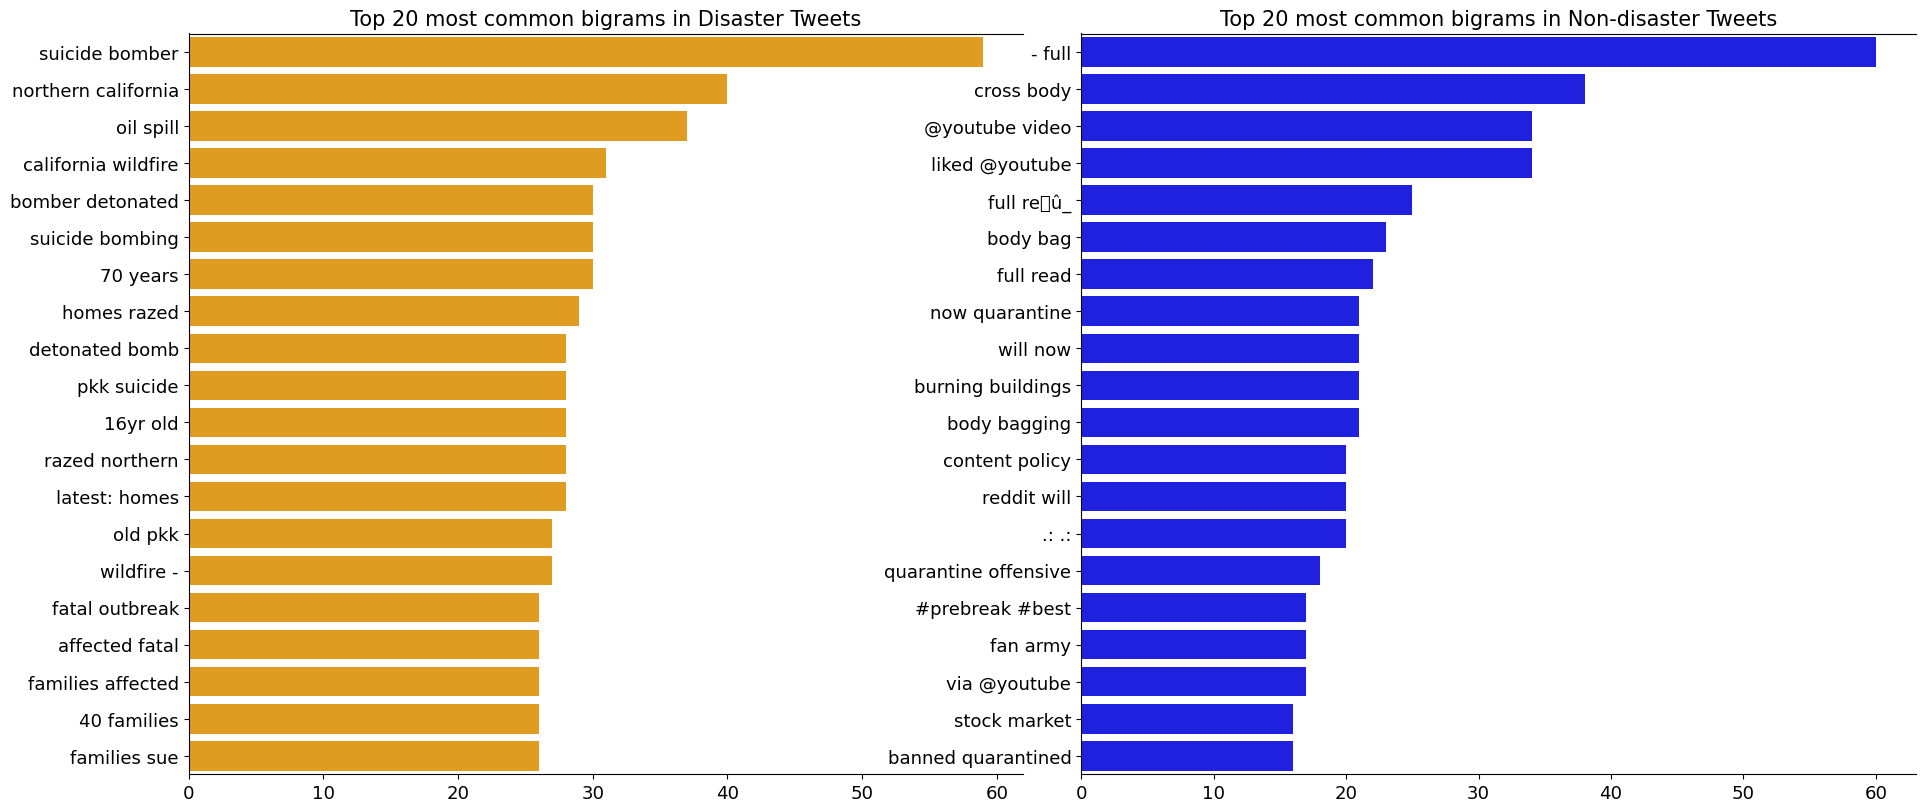

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8), dpi=100)
plt.tight_layout()

sb.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='orange')
sb.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

- Most common bigrams in disaster tweets are giving more information about the disaster than unigrams.
- There are no common bigrams in both classes.

##### 3.5.3 Trigrams

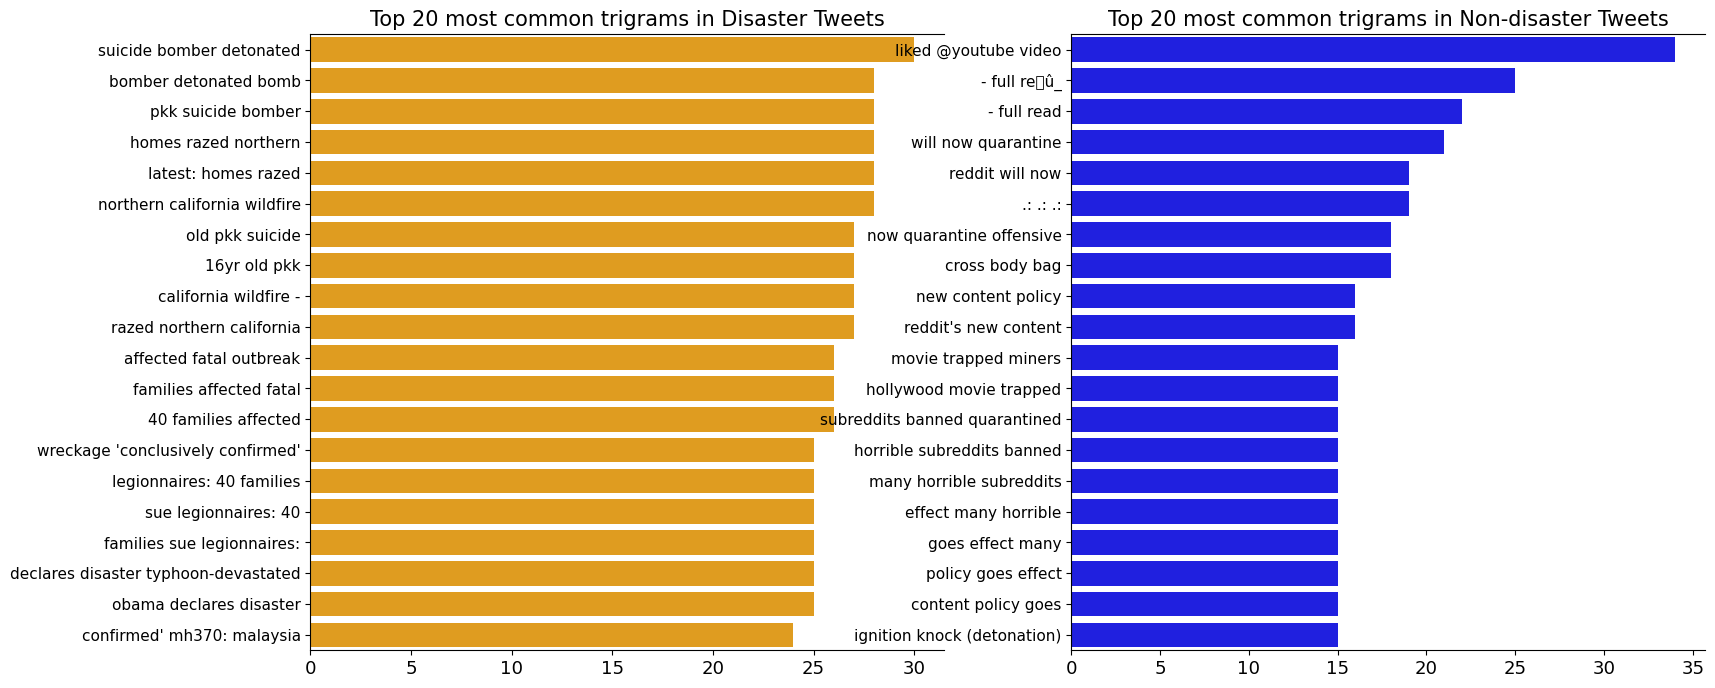

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8), dpi=100)

sb.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='orange')
sb.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='blue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

Most common trigrams in disaster tweets are very similar to bigrams. The same thing for the non-disaster tweets.

### 4. Data cleaning

In this section, I will use a number of text normalization processes like convertion to lowercase, removal of url, decontraction and others.

In [62]:
stemmer = SnowballStemmer("english")

def preprocess_data(df_train):
    
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',df_train) 
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    

    # Lowering all the words in text
    text = text.lower()
    text = text.split()
    
    text = [stemmer.stem(words) for words in text if words not in STOPWORDS]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>2] 
    text = ' '.join(text)
    return text

df_train["Cleaned_text"] = df_train["text"].apply(preprocess_data)
df_test["Cleaned_text"] = df_test["text"].apply(preprocess_data)

In [61]:
df_train.head()

,id,keyword,location,text,target,word_count,unique_word_count,Cleaned_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,deed reason earthquak may allah forgiv
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,forest fire near rong sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,resid ask ishelt place notifi offic evacu shel...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,peopl receiv wildfir evacu order california
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,got sent photo rubi alaska smoke wildfir pour ...


In [63]:
df_test.head()

,id,keyword,location,text,word_count,unique_word_count,Cleaned_text
0,0,no_keyword,no_location,Just happened a terrible car crash,6,6,happen terribl car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s...",9,9,heard earthquak differ citi stay safe everyon
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are...",19,19,forest fire spot pond gees flee across street ...
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires,4,4,apocalyps light spokan wildfir
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan,8,8,typhoon soudelor kill china taiwan


Now, I will remove unwanted words with high frequency because our text still contains some unnecessary words that are not relevant for the model and can lead to a false prediction.


In [64]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(df_train):
    return ' '.join(i for i in df_train.split() if i not in common_words)

df_train["Cleaned_text"] = df_train["Cleaned_text"].apply(text_cleaning)

### 5. Bag of words model

Bag of words is a representation of text that describes the occurrence of words within a document but no information about the order or structure of words in the document.

#### 5.1 Spliting cleaned data

In [74]:
df_clean = df_train['Cleaned_text']
df_original = df_train['text']
df_y = df_train['target']

I will use scikit-learn's train_test_split to split the data into training and validation dataset

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(df_clean, df_y, test_size=0.2, random_state=42, stratify=df_y)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [76]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6090,), (1523,), (6090,), (1523,))

For Bag of words approach I use scikit-learn's CountVectorizer.

In [77]:
def encoding_bow(train_data,valid_data,bow=False,n=1):
    if bow==True:
        cv = CountVectorizer(ngram_range=(n,n))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_valid = cv.transform(valid_data).toarray()
        valid_df = pd.DataFrame(cv_df_valid,columns=cv.get_feature_names())
        
    return train_df,valid_df

In [78]:
X_train_bow , X_valid_bow = encoding_bow(X_train,X_valid,bow=True)

#### 5.2 Training Random Forest Classifier Model

Random forests is a supervised learning algorithm that creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting.

Now let's create a RandomForestClassifier model and train it.

In [113]:
model_bow_logreg = RandomForestClassifier()
model_bow_logreg.fit(X_train_bow,y_train)
pred_bow_logreg = model_bow_logreg.predict(X_valid_bow)

Let's Print classification report and plot confusion matrix for the predictions made by the Random Forest model

In [118]:
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred,cmap = "Blues"):
    mtx = confusion_matrix(y_true, y_pred)
    sb.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap=cmap, cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Classifictaion Report
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       869
           1       0.79      0.65      0.72       654

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523

Accuracy : 0.778069599474721


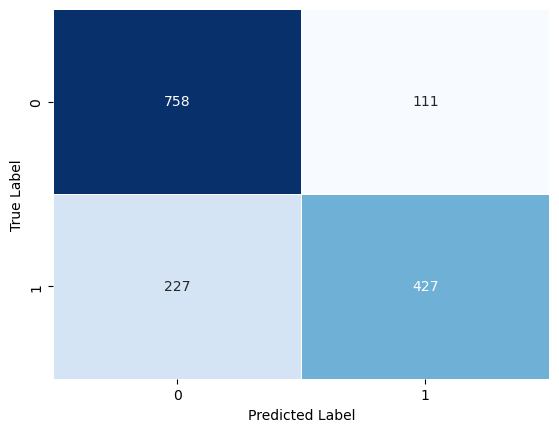

In [119]:
acc_bow_logreg = c_report(y_valid,pred_bow_logreg)
plot_cm(y_valid,pred_bow_logreg)

In [120]:
def plotROC(act,pred):
   
    false_positive_rate, true_positive_rate, thresholds = roc_curve(act, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'m--')
    plt.xlim([0,1])
    plt.ylim([0,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
   

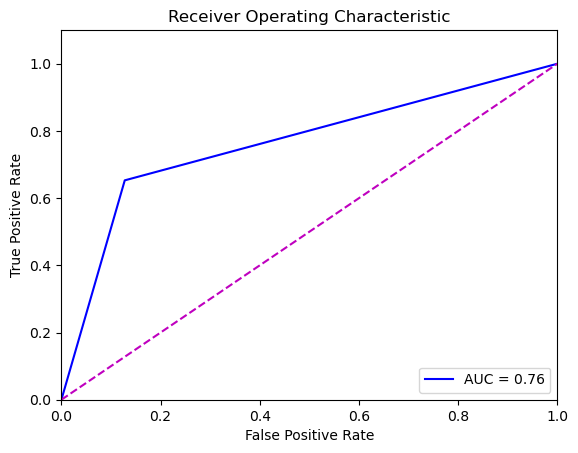

In [121]:
plotROC(y_valid,pred_bow_logreg)

# Task 2

### 6. TF-IDF (Term Frequency and Inverse Document Frequency)

TF-IDF is a technique in Natural Language Processing for converting words in Vectors. It gives weighted to uncommon words and then reflect how relevant a term is in a given document.

For TF-IDF approach I use scikit-learn's TfidfVectorizer

In [122]:
def encoding_tfidf(train_data,valid_data,tf_idf=False,n=1):
     
    if tf_idf==True:
        
        tfidf = TfidfVectorizer(ngram_range=(n, n), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df2 = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_valid = tfidf.transform(valid_data).toarray()
        valid_df2 = pd.DataFrame(tf_df_valid,columns=tfidf.get_feature_names())
        
    return train_df2,valid_df2

In [123]:
X_train_tfidf1 , X_valid_tfidf1 = encoding_tfidf(X_train,X_valid,tf_idf=True) 
X_train_tfidf2 , X_valid_tfidf2 = encoding_tfidf(X_train,X_valid,tf_idf=True,n=2) # bigrams
X_train_tfidf3 , X_valid_tfidf3 = encoding_tfidf(X_train,X_valid,tf_idf=True,n=3) # Trigrams

#### 6.1 Training Logistic Regression Models

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more independent variables.

Let's use tf-idf approach with n = 1 to train the Logistic Regression model

In [124]:
model_tfidf1_logreg = LogisticRegression()
model_tfidf1_logreg.fit(X_train_tfidf1,y_train)
pred_tfidf1_logreg = model_tfidf1_logreg.predict(X_valid_tfidf1)

Let's Print classification report and plot confusion matrix for the predictions made by the Logistic Regression model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8214051214707814


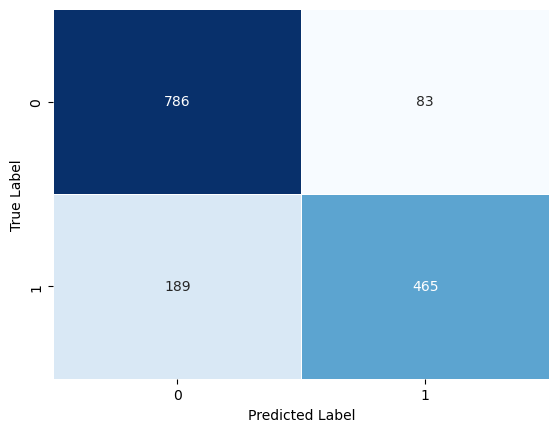

In [125]:
acc_tfidf1_logreg = c_report(y_valid,pred_tfidf1_logreg)
plot_cm(y_valid,pred_tfidf1_logreg)

Now let's use tf-idf approach with n = 2 to train the Logistic Regression model

In [126]:
model_tfidf2_logreg = LogisticRegression()
model_tfidf2_logreg.fit(X_train_tfidf2,y_train)
pred_tfidf2_logreg = model_tfidf2_logreg.predict(X_valid_tfidf2)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       869
           1       0.91      0.47      0.62       654

    accuracy                           0.75      1523
   macro avg       0.81      0.72      0.72      1523
weighted avg       0.79      0.75      0.73      1523

Accuracy : 0.7524622455679579


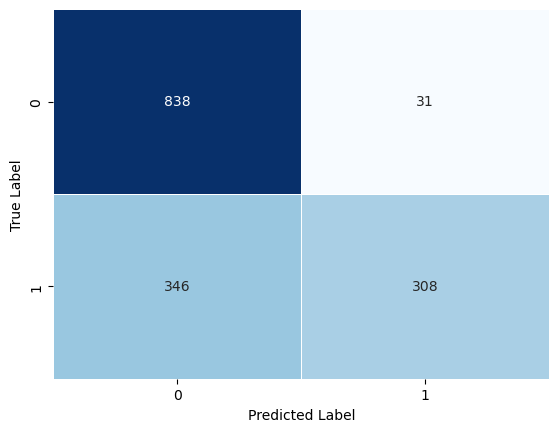

In [127]:
acc_tfidf2_logreg = c_report(y_valid,pred_tfidf2_logreg)
plot_cm(y_valid,pred_tfidf2_logreg)

From the results above we can see that n-grams = 1 gives the best accuracy 0.82.

I chose Logistic Regression instead of other methods like Random Forest Classifier because:
- Logitic Regression is more interpretable and explainable than Random Forest.
- Less prone to overfitting when using regularization with Logistic Regression.
- Training complexity can be high with Random Forest Classifier.

# Task 3

### 7. Pre-trained word embeddings and linear classifier model

#### 7.1  Embeddings

Text cleaning is based on the embeddings below:
- GloVe-840B-300d

In [130]:
glove_embeddings = np.load('/Users/basmazahraoui/Desktop/tweet desaster/glove.840B.300d.pkl', allow_pickle=True)

Now I need to get vocabulary as close to embeddings as possible. In order to do that, train vocab and test vocab are created by counting the words in tweets.

In [153]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {} #intersection of vocab and embeddings are stored here.
    oov = {} # Words in vocab that don't exist in embeddings are stored here.   
    n_covered = 0 # n_covered and n_oov are total number of counts and they are used for calculating coverage percentages
    n_oov = 0 
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training data'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test data'.format(test_glove_vocab_coverage, test_glove_text_coverage))



GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training data
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test data


Both Training and Test data with GloVe embeddings have more than 50% vocabulary and 80% text coverage without cleaning. 

#### 7.2  Text cleaning

Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.
- I will use training and test data that I cleaned before ( section 4. data cleaning )

In [155]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train["Cleaned_text"], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test["Cleaned_text"], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training data'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test data'.format(test_glove_vocab_coverage, test_glove_text_coverage))


GloVe Embeddings cover 64.25% of vocabulary and 86.90% of text in Training data
GloVe Embeddings cover 69.62% of vocabulary and 87.08% of text in Test data


In [156]:
del glove_embeddings, train_glove_oov, test_glove_oov
gc.collect()

2337

#### 7.3  Training Stochastic Gradient Descent Model

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions.

Let's train the SGD model

In [147]:
sgd = SGDClassifier(loss = 'log', penalty = 'l2', alpha = 0.0001, l1_ratio = 0.15, fit_intercept = True, max_iter = 1000, tol = 0.001, shuffle = True, verbose = 0, epsilon = 0.1, n_jobs = None, random_state = None, learning_rate = 'optimal', eta0 = 0.0, power_t = 0.5, early_stopping = False, validation_fraction = 0.1, n_iter_no_change = 5, class_weight = None, warm_start = False, average = False) # loss = 'hinge'

In [161]:

sgd.fit(X_train_tfidf1,y_train)
pred_sgd = sgd.predict(X_valid_tfidf1)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       869
           1       0.85      0.53      0.65       654

    accuracy                           0.76      1523
   macro avg       0.79      0.73      0.73      1523
weighted avg       0.78      0.76      0.75      1523

Accuracy : 0.7583716349310571


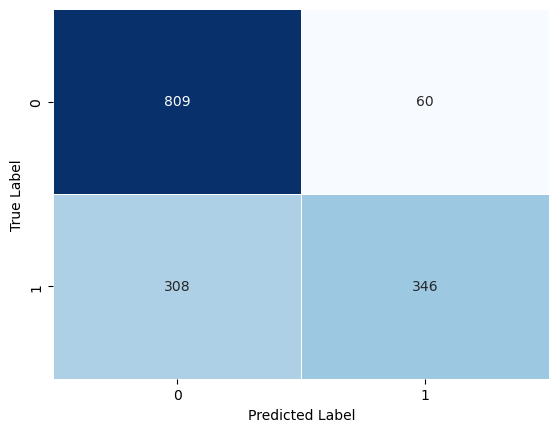

In [149]:
acc_sgd = c_report(y_valid,pred_sgd)
plot_cm(y_valid,pred_sgd)

# Task 4

### 8. Conclusion and recommendations

Among all classification models used above Logistic Regression with tf-idf and ngrams = 1 is more interpretable and explainable.
- It would be useful to train other models like eXtreme Gradient Boosting Classifier,Multinomial Naive Bayes, CatBoostClassifier, Voting Classifier and compare the accuracy of all these models and then we could decide the right compromise between explainability and accuracy depending on the business need.
- It would be recommended to spend more time on cleaning data to improve model performance.
- It would be better to use cross validation to test the ability of a machine learning model to predict new data. It is also used to flag problems like overfitting or selection bias and gives insights on how the model will generalize to an independent dataset.
- It would be useful also to train some deep learning models and compare them with machine learning models.
- You should know that Machine learning and deep learning techniques allow us to tune hyperparameters to find the best performance.
- The quality of data is key to making accurate, informed decisions by machine learning.
- What you need to keep in mind that every machine learning algorithm has advantages et desadvantages, so we need to be carefull when we use them on applications.
